https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, sys

from custom_functions import *
from datetime import time
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from feature_importance import FeatureImportance
from sklearn.tree import plot_tree


from imblearn.over_sampling import SMOTE

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 0

raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
UNKNOWN = 'Not provided'
N_SPLITS = 3
JOBS = 1

In [2]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [3]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)

# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': 'Blunt/Striking', 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': UNKNOWN, 
                    'Blunt Object/Striking Implement': 'Blunt/Striking', 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': UNKNOWN, 
                    'None/Not Applicable': 'None', 
                    'Club': 'Blunt/Striking', 
                    'Taser/Stun Gun': UNKNOWN, 
                    'Shotgun': 'Firearm', 
                    'Brass Knuckles': 'Blunt/Striking', 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': 'Blunt/Striking', 
                    'Personal Weapons (hands, feet, etc.)': 'Blunt/Striking'}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)



# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')



# Officer Race
race_dict = {'Unknown': UNKNOWN, 
            'Not Specified': UNKNOWN,
            '-': UNKNOWN,
            'Other': UNKNOWN, 
            'Unknown': UNKNOWN}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)



# Gender
gender_dict = {'Unable to Determine': UNKNOWN,
              '-': UNKNOWN,
               'Unknown': UNKNOWN,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)



# Race - grouped for naming consistency and aggregating small sample sizes for statistical significance
race_dict = {'Two or More Races': 'Multi-Racial',
            'Hispanic or Latino': 'Hispanic',
            'Nat Hawaiian/Oth Pac Islander': 'Native', 
            'American Indian/Alaska Native': 'Native',
            'Native Hawaiian or Other Pacific Islander': 'Native',
            'American Indian or Alaska Native': 'Native'}
df['Subject Perceived Race'].replace(race_dict, inplace=True)
df['Officer Race'].replace(race_dict, inplace=True)



# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)

# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                 'Unknown': UNKNOWN,
                'SouthWest': 'Southwest'}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)

# Beat
df['Beat'].replace(['S', '99', '-'], UNKNOWN, inplace=True)

# Subject age group
df['Subject Age Group'].replace('-', np.nan, inplace=True)


# Required for downstream one-hot encoding. Don't delete
df['Officer Squad'].fillna(UNKNOWN, inplace=True)

df.dropna(inplace=True) # uncomment!!!!!!!

# Feature Engineering

### Age group manipulation

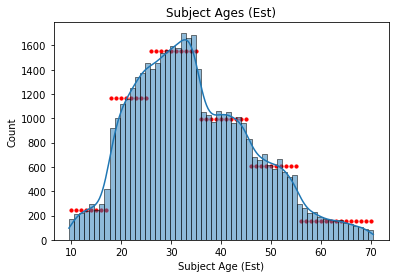

In [4]:

# ------ ESTIMATE SUBJECT AGE ------

years_in_category = {'1 - 17': [10, 17],
'18 - 25': [18, 25],
'26 - 35': [26, 35],
'36 - 45': [36, 45],
'46 - 55': [46, 55],
'56 and Above': [56, 70]}

def predict_ages():
    avg, std, x, y = calculate_mean_and_std()    
    ages = []
    for age_categorical in df['Subject Age Group']:
        age = predict_age_from_category(age_categorical, avg, std)
        ages.append(age)
    return ages, x, y


def calculate_mean_and_std():
    xy = {}
    age_group_counts = dict(df['Subject Age Group'].value_counts())
    
    for age_group in df['Subject Age Group'].replace(UNKNOWN, np.nan).dropna().unique():
        age_range_list = set_range(age_group)
        age_range_ct = age_group_counts[age_group]
        
        for item in age_range_list:
            xy[item] = int(age_range_ct/len(age_range_list))
    
    x = np.array(list(xy.keys()))
    y = np.array(list(xy.values()))
    avg = x.mean()
    std = x.std()
    return avg, std, x, y



def set_range(age_range):
    age_range = years_in_category[age_range]
    start = age_range[0]
    stop = age_range[1]
    return np.linspace(start, stop, stop-start+1)

def predict_age_from_category(bucket, avg, std):
    if bucket == UNKNOWN:
        year_range = np.array(list(years_in_category.values())).flatten()
        min_age = year_range.min()
        max_age = year_range.max()
    else:
        year_range = years_in_category[bucket]
        min_age = year_range[0]
        max_age = year_range[1]
    age = 0
    while ((age <= min_age-0.5) or (age > max_age+0.5)):
        age = np.random.normal(avg, std)
    return age


plt.figure()
df['Subject Age (Est)'], x, y = predict_ages()
sns.histplot(df['Subject Age (Est)'], bins=60, kde=True);
plt.scatter(x, y, c='r', s=10)
plt.title('Subject Ages (Est)');

In [5]:
# Engineer new features

# Calculate Officer Age
if 'Officer YOB' in df.columns:
    df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
    median_yob = int(df['Officer YOB'].median())
    df['Officer Age'] = df['Officer Age'].apply(lambda x: median_yob if x > 100 else x)
    df.drop('Officer YOB', axis=1, inplace=True)

    
# Determine whether or not weapon was involved
#has_weapon = lambda x: 'No' if x == 'None' else 'Yes'
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')


# Calculate the number of stops per subject
if 'Subject ID' in df.columns:
    offense_ct_dict = dict(df['Subject ID'].value_counts())
    df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)
    # Identify whether a subject has been involved in multiple stops
    df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')
    # Drop "Offense Count" for now given the number of missing values
    if 'Offense Count' in df:
        df.drop('Offense Count', axis=1, inplace=True)
    df.drop('Subject ID', axis=1, inplace=True)


# Identify whether race of officer is same as race of subject
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Identify whether gender of officer is same as gender of subject
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

# Rename columns and drop 'na' rows
if 'Arrest Flag' in df.columns:
    df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
    df.drop('Arrest Flag', axis=1, inplace=True)
    
if 'Frisk Flag' in df.columns:
    df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
    df.drop('Frisk Flag', axis=1, inplace=True)
    
# Stop resolution
df['Stop Resolution: Arrest (Method2)'] = (df['Stop Resolution'] == 'Arrest').astype('int')


# Revisiting subject perceived gender
# Difficult decision to make, but with a sample size of only 5 people, the 
# amount of data is insufficient to provide a statistically significant understanding
# of how non-binary perception affects arrest rate
df['Subject Perceived Gender'].replace('Non-Binary', UNKNOWN, inplace=True)
df['Officer Gender'].replace('Non-Binary', UNKNOWN, inplace=True)

# Optionally categorize 'Officer Squad'
# Officer Squad

In [6]:
# Remove missing values and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

### Determine which "Arrest" field to use:
- Option 1: 'Arrest Flag', which is now renamed to 'Arrest (Y/N)'
- Option 2: 'Stop Resolution' value of 'Arrest'

In [7]:
print('Option 1:')
print(df['Arrest (Y/N)'].value_counts())
print('\nOption 2:')
print(df['Stop Resolution: Arrest (Method2)'].value_counts())

Option 1:
0    41830
1     3439
Name: Arrest (Y/N), dtype: int64

Option 2:
0    33902
1    11367
Name: Stop Resolution: Arrest (Method2), dtype: int64


##### Since there are more in Option 2, determine if all positives from Option 1 are included in this subset

In [8]:
# Determine if all of
method2 = df.loc[df['Stop Resolution: Arrest (Method2)']==1].copy()
method2['Arrest (Y/N)'].value_counts()

0    7930
1    3437
Name: Arrest (Y/N), dtype: int64

##### All but 2 of the positive Arrest (Y/N) values are included in 'Stop Resolution: Arrest'. As a result, we see that the former is a subset of the latter. It is unclear why, but for the scope of this analysis, we will use the latter for the sake of a larger scope. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45269 entries, 0 to 45268
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Subject Age Group                  45269 non-null  object        
 1   GO / SC Num                        45269 non-null  object        
 2   Terry Stop ID                      45269 non-null  object        
 3   Stop Resolution                    45269 non-null  object        
 4   Weapon Type                        45269 non-null  object        
 5   Officer ID                         45269 non-null  object        
 6   Officer Gender                     45269 non-null  object        
 7   Officer Race                       45269 non-null  object        
 8   Subject Perceived Race             45269 non-null  object        
 9   Subject Perceived Gender           45269 non-null  object        
 10  Reported Date                     

In [10]:
df.rename({'Stop Resolution: Arrest (Method2)':'Stop Resolution: Arrest (Y/N)'}, axis=1, inplace=True)
df.drop('Arrest (Y/N)', axis=1, inplace=True)

# Graphical EDA

In [11]:
# # BAR GRAPHS FOR ***AVERAGE OR SUM*** OF METRICS

# df_graphical = pd.concat([df, pd.get_dummies(df['Stop Resolution'], prefix='Resolution')], axis=1)

# # Average metrics by age group
# x_axis = 'Subject Age Group'
# y_axis = ['Stop Resolution: Arrest (Y/N)', 'Frisk (Y/N)']#, 'Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
# bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=False)

# # Average metrics by subject race
# x_axis = 'Subject Perceived Race'
# y_axis = ['Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
# bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# # Gender metrics
# x_axis = 'Subject Perceived Gender'
# y_axis = ['Stop Resolution: Arrest (Y/N)', 'Frisk (Y/N)']
# bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# # Officer race
# x_axis = 'Officer Race'
# bar_plot(df_graphical, x_axis, y_axis, 'mean',verbose=True)

# # Officer gender
# x_axis = 'Officer Gender'
# bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# # Officer age
# x_axis = 'Officer Age'
# bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Refine dataset

In [12]:
# Refine dataset to continuous and categoricals w/reasonable number of unique values

# Separate columns by type
obj_columns = df.select_dtypes('object').columns
continuous_columns = df.drop(obj_columns, axis=1).columns

# Determine which columns are most valuable to OHE
# based on small enough number of values
cols_to_ohe = []
for col in obj_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)
    else:
        print('Excluding:', col)

df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)

print(f'Including: {df_refined.columns}')
#df_refined.info()

Excluding: GO / SC Num
Excluding: Terry Stop ID
Excluding: Officer ID
Excluding: Reported Time
Excluding: Initial Call Type
Excluding: Final Call Type
Excluding: Officer Squad
Excluding: Beat
Including: Index(['Reported Date', 'Subject Age (Est)', 'Officer Age', 'Weapon (Y/N)',
       'Repeat Offender (Y/N)', 'Same Race (Y/N)', 'Same Gender (Y/N)',
       'Frisk (Y/N)', 'Stop Resolution: Arrest (Y/N)', 'Subject Age Group',
       'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Call Type',
       'Precinct', 'Sector'],
      dtype='object')


##### Plot distributions

In [13]:
# #nrows = int(np.ceil(len(continuous_columns)/4))
# nrows = int(np.ceil(df_refined.shape[1]/4))
# fig, axes = plt.subplots(ncols=4, nrows=nrows, figsize=(22, 4*nrows))

# for ax, col in zip(axes.flatten(), df_refined.columns):
#     ax.hist(df_refined[col])
#     ax.set_title(col)
#     ax.tick_params('x', labelrotation=45)
#     #ax.tick_params(labelrotation=45)
    
# plt.subplots_adjust(wspace=.75, hspace=.75)

# Begin Modeling

Which features have a connection with y?

In [14]:
col = df_refined.columns[0]

df_refined.corr()

,Subject Age (Est),Officer Age,Weapon (Y/N),Repeat Offender (Y/N),Same Race (Y/N),Same Gender (Y/N),Frisk (Y/N),Stop Resolution: Arrest (Y/N)
Subject Age (Est),1.000000,0.003629,0.015961,-0.059077,0.042495,0.049249,-0.032164,-0.013492
Officer Age,0.003629,1.000000,-0.001571,-0.009316,-0.000076,-0.029454,-0.011163,-0.019449
Weapon (Y/N),0.015961,-0.001571,1.000000,-0.010797,0.022367,0.070006,0.376407,0.111760
Repeat Offender (Y/N),-0.059077,-0.009316,-0.010797,1.000000,0.055296,0.010693,-0.040161,-0.018868
Same Race (Y/N),0.042495,-0.000076,0.022367,0.055296,1.000000,-0.013593,-0.054436,-0.013688
Same Gender (Y/N),0.049249,-0.029454,0.070006,0.010693,-0.013593,1.000000,0.110849,0.023871
Frisk (Y/N),-0.032164,-0.011163,0.376407,-0.040161,-0.054436,0.110849,1.000000,0.144243
Stop Resolution: Arrest (Y/N),-0.013492,-0.019449,0.111760,-0.018868,-0.013688,0.023871,0.144243,1.000000


In [15]:
df_refined.loc[df_refined['Stop Resolution: Arrest (Y/N)'] == 1].sum()

Subject Age (Est)                                                    389101.815029
Officer Age                                                                 387575
Weapon (Y/N)                                                                  1203
Repeat Offender (Y/N)                                                         9442
Same Race (Y/N)                                                               4443
Same Gender (Y/N)                                                             8483
Frisk (Y/N)                                                                   3760
Stop Resolution: Arrest (Y/N)                                                11367
Subject Age Group                1 - 171 - 171 - 171 - 171 - 171 - 171 - 171 - ...
Stop Resolution                  ArrestArrestArrestArrestArrestArrestArrestArre...
Weapon Type                      NoneNoneNoneNoneNoneNoneFirearmNoneNoneNoneFir...
Officer Gender                   MaleMaleFemaleMaleMaleMaleMaleMaleMaleMaleMale...
Offi

In [16]:
# Split data
y_label = 'Stop Resolution: Arrest (Y/N)'
X = df_refined.drop([y_label,
                     'Frisk (Y/N)', 
                     'Reported Date', 
                     'Subject Age Group', 
                     'Stop Resolution',
                     'Call Type', 
                     'Precinct',
                     'Sector'], 
                     axis=1)
y = df_refined[y_label]

X, X_test, y, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# Remove temptation to touch test dataset
test_data = {'X_test': X_test, 'y_test': y_test}
with open (os.path.join(processed_data_path, 'test_data.pickle'), 'wb') as f:
    pickle.dump (test_data, f)
X_test = None
y_test = None
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Declare object to hold history of all model runs
model_history = ModelHistory()

## Create Transformer and Model Objects

In [17]:
# One hot encoder
droppers = [UNKNOWN]*X.select_dtypes('object').shape[1]
one_hot_encoder = OneHotEncoder(drop=droppers, sparse=False)

# Selectors
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number')


# Column transformers
transformer_basic = make_column_transformer((one_hot_encoder, string_selector), n_jobs=JOBS)

transformer_ss = make_column_transformer((one_hot_encoder, string_selector), 
                                          (StandardScaler(), number_selector), n_jobs=JOBS)

transformer_minmax = make_column_transformer((one_hot_encoder, string_selector), 
                                             (MinMaxScaler(), number_selector), n_jobs=JOBS)


# K-Fold cross validation
kfold = KFold(N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Resampling (smote)
smote = SMOTE(random_state = RANDOM_STATE, n_jobs=JOBS)

# Models
model_logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000, n_jobs=JOBS)
model_knn = KNeighborsClassifier(n_jobs=JOBS)
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state=RANDOM_STATE, n_jobs=JOBS)

### Logistic Regression

In [18]:
# # # --- BASELINE (CONTINUOUS) ---
# X_numeric = X.select_dtypes(exclude='object')
# model_logreg.fit(X_numeric, y)
# model_history.add_model(model_logreg, X_numeric, y, notes='Logreg baseline')

# # # --- ADD CATEGORICALS ---
# pipe = Pipeline([('cols', transformer_basic),
#                  ('model', model_logreg)])
# pipe.fit(X, y)
# model_history.add_model(pipe, X, y, notes='logreg, add categoricals')


# # # --- ADD SMOTE ---
# pipe = Pipeline([('cols', transformer_basic),
#                  ('smote', smote),
#                  ('model', model_logreg)])
# pipe.fit(X, y)
# model_history.add_model(pipe, X, y, notes='logreg, add SMOTE')


# # # --- ADD STANDARD SCALER ---
# pipe = Pipeline([('cols', transformer_ss),
#                  ('smote', smote),
#                  ('model', model_logreg)])
# pipe.fit(X, y)
# model_history.add_model(pipe, X, y, notes='logreg, add standard scaler')


# # # --- SWITCH TO MIN-MAX SCALER ---
# pipe = Pipeline([('cols', transformer_minmax),
#                  ('smote', smote),
#                  ('model', model_logreg)])
# pipe.fit(X, y)
# model_history.add_model(pipe, X, y, notes='logreg, switch to min-max scaler')


# # --- ADD GRID SEARCH AND CROSS VAL ---
pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_logreg)])
param_grid = {'model__C': np.logspace(-4, 4, 25)}
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='logreg, add grid search and cross val')

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.397216,0.568938,"logreg, add grid search and cross val"


Train: 0.38409738286849304
Test: 0.37767532893890127


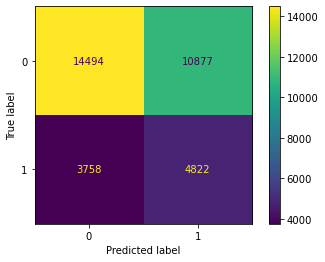

In [19]:
train_test_scores(search)
plot_confusion_matrix(search.best_estimator_, X, y);

### K-Nearest Neighbors

In [20]:
# --- GRID NEEDS BETTER PARAMETER CHOICES ---
pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_knn)])

param_grid = {'model__leaf_size': [50],
               'model__n_neighbors': np.arange(3, 8, 2)} 
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid search KNN')

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.397216,0.568938,"logreg, add grid search and cross val"
1,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.572408,0.705959,grid search KNN


Train: 0.6273361935094655
Test: 0.3406432026185872


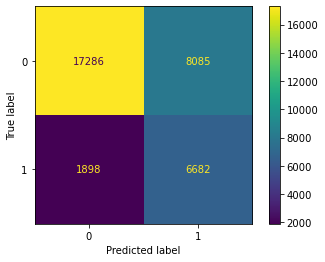

In [22]:
train_test_scores(search)
plot_confusion_matrix(search.best_estimator_, X, y);

### Decision Tree

In [23]:
pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_dt)])

param_grid = {'model__max_depth': [2, 6, 10], 
              'model__criterion': ['gini', 'entropy'],
              'model__min_samples_split': [5, 10],
              'model__min_samples_leaf': [5, 10]} 

search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid-based decision tree')

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.397216,0.568938,"logreg, add grid search and cross val"
1,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.572408,0.705959,grid search KNN
2,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.401341,0.495008,grid-based decision tree


Train: 0.3901682489536122
Test: 0.382614081200431


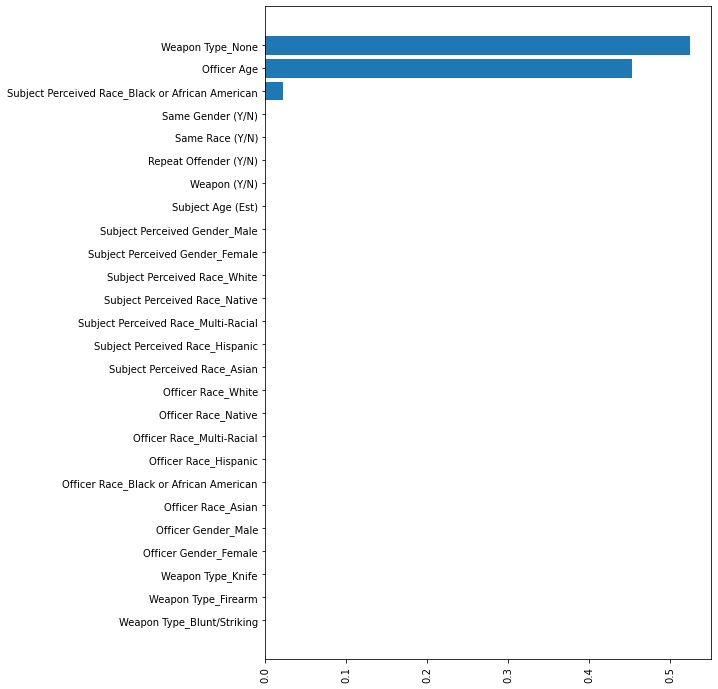

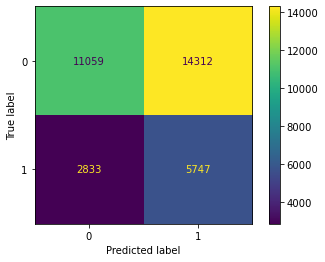

In [24]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(search.best_estimator_, X, y);

In [27]:
# # # --- PLOT TREE
# best_pipe = search.best_estimator_
# ohe_names = best_pipe[0].transformers_[0][1].\
#             get_feature_names(X.select_dtypes('object').columns)
# numeric_names = best_pipe[0].transformers_[1][2]
# feature_names = list(ohe_names)+numeric_names
# plot_tree(best_pipe, 
#           feature_names = feature_names, 
#           class_names=np.unique(y).astype('str'),
#           filled=True, rounded=True)

### Random Forest

In [28]:
param_grid = {
    'model__n_estimators': [10, 30],#, 100],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [2, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}


pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_rf)])
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid-based RF')

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.397216,0.568938,"logreg, add grid search and cross val"
1,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.572408,0.705959,grid search KNN
2,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.401341,0.495008,grid-based decision tree
3,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.417468,0.605520,grid-based RF


Train: 0.3650676974254088
Test: 0.3456272366557777


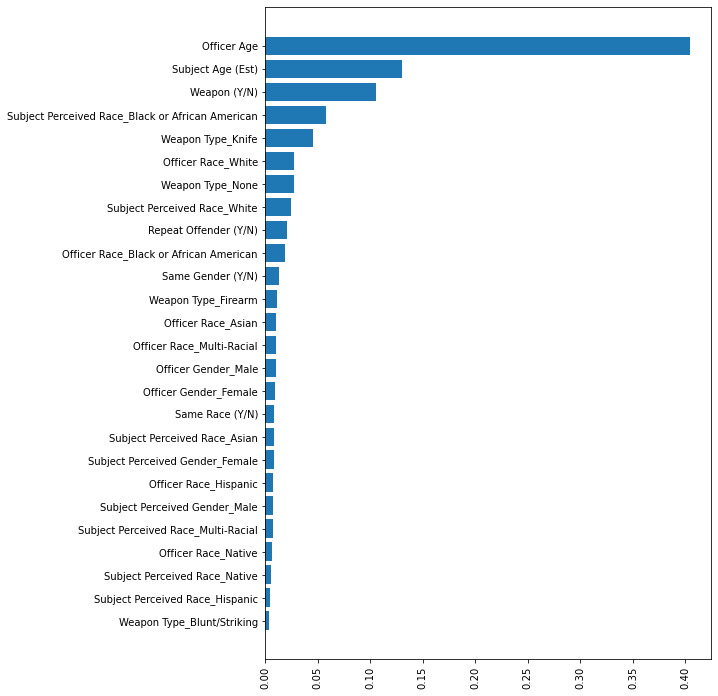

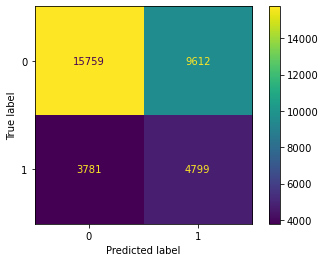

In [29]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(search.best_estimator_, X, y);

### XG Boost

In [30]:
param_grid = {
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 6],
    'model__min_child_weight': [1, 2],
    'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100]}

pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_xgb)])

search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', return_train_score=True)
search.fit(X, y)
model_history.add_model(search.best_estimator_, X, y, display_results=True, notes='grid-based xgb')

,Model,n_features,Features,F1 Score,Accuracy,Notes
0,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.397216,0.568938,"logreg, add grid search and cross val"
1,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.572408,0.705959,grid search KNN
2,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.401341,0.495008,grid-based decision tree
3,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.417468,0.605520,grid-based RF
4,"Pipeline(steps=[('cols',\n Col...",11,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.216470,0.729846,grid-based xgb


Train: 0.20610178622542447
Test: 0.1587684531770599


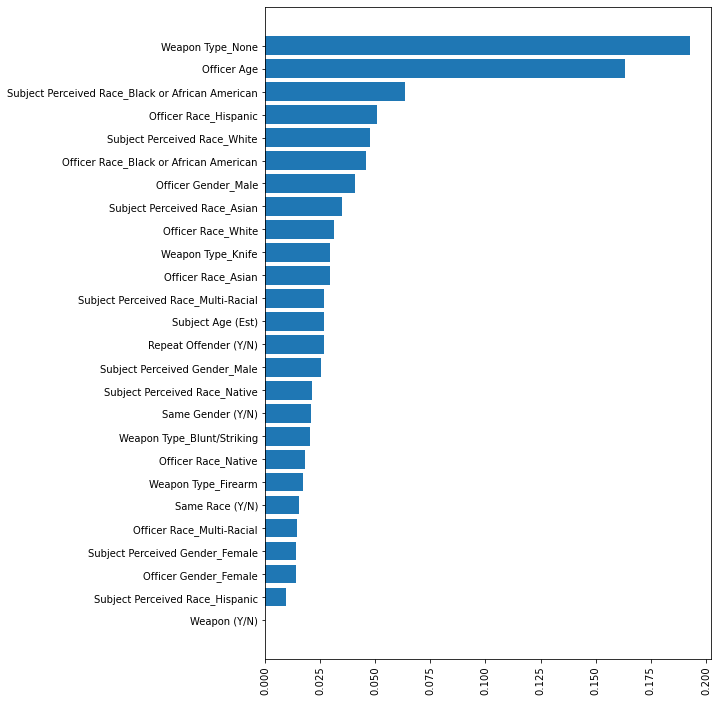

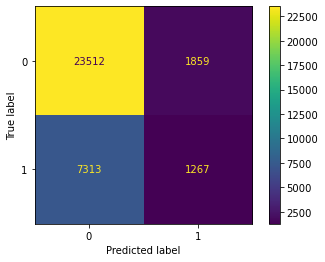

In [31]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(search.best_estimator_, X, y);

In [32]:
fp = 1783
fn = 7309
tp = 1271
tn = 23588

tp / (tp+0.5*(fp+fn))

0.21849750730617157

# To do

- Look into individual cases to see why resolution would be set as Arrest, yet arrest flag was not flipped
- Once a model is selected, how should the results be presented?
    - Back up any sort of conclusion with hypothesis testing
    - If it is a tree-based model, consider printing out the graphical representation of the tree that was used
    - Regarding how to gain meaning from results:
        - Perhaps use hypothesis testing to see extent of results
        - If linear model: bootstrapping can be used to get coefficients
        - If non-linear (non-parametric) models: once final model is selected, run it again without race (e.g.) to see how error changes. Also see how much the error changes when dropping other features?
    - Could also use step-forward (e.g.) feature selection function that was implemented in the lab project. Make sure to change from R2 eval metric to F1 (or whatever I end up using). Also make sure this is looking at the result on validation data, not just overall data (reduce overfitting). 
    
- Try running from scratch with different 'Arrest' flag metric
- Where input (e.g. Officer Age) is continuous: run hypothesis test. Alternatively, do bootstapping for categorical  

# Questions
- Why does F1 get worse for logreg once GridSearch is implemented?
- In cases of grid search, should I be just adding best_estimator_ to the model history to avoid re-running everything within the model history object?
- Discuss age interpolation function
- How do I decide which "arrest metric" to use?

##### For report "next steps" section:
- More formulaic feature selection process
- Create model for filling in missing ages instead of dropping values